In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import NeighborSampler
from torch_geometric.datasets import Planetoid, WikipediaNetwork, Actor, WebKB

from modules.model import Net
from modules.sampling import SamplerContextMatrix, SamplerRandomWalk, SamplerFactorization, SamplerAPP

In [54]:
synthetic = True
benchmark_data_dir = "../data_benchmark/"
help_data = "../data_help/"

In [40]:
import random
random.sample([1,2,3,4,5,6,7,8,9],k=3)

[4, 7, 9]

In [41]:
if synthetic:
    datasets_names=[]
    for l_a_trgt in [0.1,0.5,0.9]:
                for f_a_trgt in [0.1,0.5,0.9]:
                    for cl_trgt in [0.01,0.1,0.2,0.3,0.5]:
                        for asp_trgt in [2,3,4,5,6,7]:
                            for a_deg_trgt in [2,5,10,15,20,25,30,35,40]:
                                datasets_names.append((l_a_trgt,f_a_trgt,cl_trgt,asp_trgt,a_deg_trgt))
    def data_load(name):
        x = torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_attr.npy'),dtype=torch.float)
        edge_list = torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_edgelist.npy')).t()

        data=Data(x=x,edge_index=edge_list)
        indices=list(range(len(data.x)))

        train_indices = random.sample(list(range(len(indices))), k = int(len(indices)*0.7))
        train_indices_torch = torch.tensor(train_indices)

        test_indices = list((set(indices)-set(train_indices)))
        test_indices_torch = torch.tensor(test_indices)
        train_mask = torch.tensor([False]*len(indices))
        test_mask = torch.tensor([False]*len(indices))
        train_mask[train_indices] = True
        test_mask[test_indices]= True

        return data, train_indices_torch,test_indices_torch,train_mask,test_mask
else:
    datasets_names = ['Cornell','Texas','Wisconsin','Actor','Pubmed','squirrel']

    def data_load(name):
        if name == 'Cora' or name == 'Citeseer' or name == 'Pubmed':
            data = Planetoid(root='/tmp/'+str(name), name=name,transform=T.NormalizeFeatures())[0]
        elif name == 'Actor':
            data = Actor(root='/tmp/actor',transform=T.NormalizeFeatures())[0]
        elif name == "Cornell" or name=="Texas" or name=="Wisconsin":
            data = WebKB(root='/tmp/'+str(name),name=name,transform=T.NormalizeFeatures())[0]
        elif name == 'squirrel' or name=='chameleon':
            data = WikipediaNetwork(root='/tmp/'+str(name), name=name,transform=T.NormalizeFeatures())[0]

        indices=list(range(len(data.x)))

        train_indices = torch.tensor(indices[:int(0.7*len(indices)+1)])
        val_indices = torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        test_indices = torch.tensor(indices[int(0.8*len(indices)+1):])
        train_mask = torch.tensor([False]*len(indices))
        test_mask = torch.tensor([False]*len(indices))
        val_mask = torch.tensor([False]*len(indices))
        train_mask[train_indices] =True
        test_mask[test_indices]=True
        val_mask[val_indices]=True
        return data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask

In [42]:
synthetic

True

In [43]:
#loss functions

VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}

VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler":SamplerContextMatrix,"lmbda": [0.0,1.0]}
DeepWalk = {"Name": "DeepWalk","walk_length":[5, 10, 15, 20],"walks_per_node":[5, 10, 15, 20],"num_negative_samples":[1,6, 11, 16, 21],"context_size" : [5, 10, 15, 20],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5, 10, 15, 20],"walks_per_node":[5, 10, 15, 20],"num_negative_samples":[1,6, 11, 16, 21],"context_size" : [5, 10, 15, 20],"p": [0.25, 0.50, 1, 2, 4] ,"q":[0.25, 0.50, 1, 2, 4], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое
APP ={"Name": "APP","C": "PPR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить

HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить
HOPE_CN = {"Name": "HOPE_CommonNeighbors", "C":"CN","loss var": "Factorization","flag_tosave":False,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}

LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}
LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization","flag_tosave":False,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}

Force2Vec = {"Name": "Force2Vec","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Force2Vec","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}


In [44]:
import pickle
import os
from modules.negativeSampling import NegativeSampler

class Main:
    def __init__(self,name, conv, device, loss_function, mode):
        data, train_indices,test_indices,train_mask,test_mask = data_load(name)
        self.Conv = conv
        self.device = device
        self.x = data.x
        self.data=data.to(device)
        self.loss = loss_function
        self.mode = mode
        self.datasetname=name
        self.train_indices =train_indices# torch.tensor(indices[:int(0.7*len(indices)+1)])

        self.test_indices = test_indices#torch.tensor(indices[int(0.8*len(indices)+1):])
        self.train_mask = train_mask#torch.tensor([False]*len(indices))
        self.test_mask = test_mask#torch.tensor([False]*len(indices))

        self.flag = self.loss["flag_tosave"]
        super(Main, self).__init__()
    def sampling(self,Sampler, epoch, nodes, loss,train_flag = True):
            if (epoch == 0):
                if self.flag:
                    if "alpha" in self.loss:
                        name_of_file = self.datasetname+"_samples_"+loss["Name"]+"_alpha_"+str(loss["alpha"])+".pickle"
                    elif "betta" in self.loss:
                        name_of_file = self.datasetname+"_samples_"+loss["Name"]+"_betta_"+str(loss["betta"])+".pickle"
                    else:
                        name_of_file = self.datasetname+"_samples_"+loss["Name"]+".pickle"

                    if os.path.exists(f'{help_data}/'+str(name_of_file)):
                        with open(f'{help_data}/'+str(name_of_file),'rb') as f:
                            self.samples = pickle.load(f)
                    else:
                        self.samples = Sampler.sample(nodes)
                        with open(f'{help_data}/'+str(name_of_file),'wb') as f:
                            pickle.dump(self.samples,f)
                else:
                    self.samples = Sampler.sample(nodes,train_flag)
 
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch,loss):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
       # print('train loader',len(train_loader))
        
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr = torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                #print('before',data.x)
                out = model.inference(data.to(self.device),dp=dropout)
                #print('after',out, sum(sum(out)))

                samples = self.sampling(Sampler,epoch, indices_of_train_data,loss,train_flag=True)
                loss = model.loss(out[self.train_mask], self.samples)
                #print('loss',loss)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(self.device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(self.device)].to(self.device), adjs)

                    self.sampling(Sampler,epoch,n_id[:batch_size],loss,train_flag=True)
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
            return total_loss /len(train_loader), out

    @torch.no_grad()
    def test(self, model, data,test_loader,epoch,Sampler,loss):
        model.eval()
        total_loss = 0
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr = torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                #print('before',data.x)
                out = model.inference(data.to(self.device),dp=0)
                #print('after',out, sum(sum(out)))
                samples = self.sampling(Sampler,epoch, indices_of_train_data,loss,train_flag=False)
                loss = model.loss(out[self.test_mask], self.samples)
                #print('loss',loss)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in test_loader:
                    if len(test_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(self.device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(self.device)].to(self.device), adjs)

                    self.sampling(Sampler,epoch,n_id[:batch_size],loss,train_flag=False)

                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss

            return total_loss /len(test_loader)

    def run(self,params):
        hidden_layer=params['hidden_layer']
        out_layer=params['out_layer']
        dropout=params['dropout']
        size=params['size of network, number of convs']
        learning_rate=params['lr']
        #hidden_layer_for_classifier=params['hidden_layer_for_classifier']
        #alpha_for_classifier = params['alpha_for_classifier']
        #learning_rate_for_classifier = params['learning_rate_for_classifier']
        #n_layers_for_classifier = params['n_layers_for_classifier']

        #hidden_layer=64,out_layer=128,dropout=0.0,size=1,learning_rate=0.001,c=100
        classifier = "logistic regression"
        self.data.edge_index= self.data.edge_index.type(torch.LongTensor)
        train_loader = NeighborSampler(self.data.edge_index, node_idx=torch.BoolTensor([True]*len(self.data.x)), batch_size = int(len(self.data.x)), sizes=[-1]*size)
        
        Sampler = self.loss["Sampler"]
        LossSampler = Sampler(self.datasetname, self.data, device=device, mask=torch.BoolTensor([True]*len(self.data.x)), loss_info=self.loss, help_dir=help_data)
        model = Net(dataset = self.data,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        for epoch in range(100):
                    loss,out = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,self.loss)

        np.save(str(self.datasetname)+'_'+ str(self.loss['Name'])+'_emb.npy', out.detach().cpu().numpy())

        positive_edges = []
        for edge in self.data.edge_index.T.tolist():
            if edge[0] in self.train_indices:
                if edge[1] in self.train_indices:
                    positive_edges.append(edge)

        ns = NegativeSampler(data = self.data)
        num_negative_samples = int(len(positive_edges)/len(self.train_indices))
        neg_samples = ns.negative_sampling( self.train_indices, num_negative_samples=num_negative_samples)

        # find treshold
        max_acc = 0
        max_acc_k = 0

        true = [1]*len(positive_edges)+[0]*len(neg_samples)
        emb_norm = torch.nn.functional.normalize(torch.tensor(out.detach().cpu()))
        for k in np.linspace(0,1,100).tolist():
            pred = []
            for edge in positive_edges:
                pred.append((torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])).tolist() > k)
            for edge in neg_samples:
                pred.append((torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])).tolist() > k)
            acc = accuracy_score(true,pred)
            if acc > max_acc:
                max_acc = acc
                max_acc_k = k

        positive_edges_test = []
        for edge in self.data.edge_index.T.tolist():
            if edge[0] in self.test_indices:
                if edge[1] in self.test_indices:
                    positive_edges_test.append(edge)

        num_neg_samples_test = int(len(positive_edges)/len(self.test_indices))
        ns = NegativeSampler(data=self.data)
        neg_samples_test = ns.negative_sampling( self.test_indices, num_negative_samples=num_neg_samples_test)
        pred_test=[]
        for edge in positive_edges_test:
            pred_test.append((torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])) > max_acc_k)
        #print(torch.sigmoid(torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])))
        for edge in neg_samples_test:
            pred_test.append((torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])) > max_acc_k)

        true_test = [1]*len(positive_edges_test)+[0]*len(neg_samples_test)

        return accuracy_score(true_test, pred_test)





In [45]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv
        learning_rate= trial.suggest_float("lr",5e-3,1e-2)
     #   learning_rate_for_classifier =trial.suggest_float("learning_rate_for_classifier",5e-3,1e-2)
      #  n_layers_for_classifier = trial.suggest_categorical("n_layers_for_classifier", [1,2,3])
       # alpha_for_classifier = trial.suggest_categorical("alpha_for_classifier",  [0.001, 0.01, 0.1,0.3,0.5,0.7,0.9,1,10,20,30,100])
        #c =trial.suggest_categorical("c",  [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,20,30,100])
        #hidden_layer_for_classifier = trial.suggest_categorical("hidden_layer_for_classifier", [32,64,128,256])
        # варьируем параметры
        loss_to_train={}
        for name in self.loss:
            
            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        if name =='q' and type(self.loss[name]) == list:
            var_5 = trial.suggest_categorical('p', self.loss['p'])
            var_4 = trial.suggest_categorical('q', self.loss[name])
            if var_4 > 1:
                var_4=1
            if var_5 < var_4:     
                var_5=var_4
            loss_to_train['q'] = var_4
            loss_to_train['p'] = var_5
                
        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.data,mode=self.mode,conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)
        self.data.edge_index= self.data.edge_index.type(torch.LongTensor)

        train_loader = NeighborSampler(self.data.edge_index, batch_size = int(sum(self.train_mask)),node_idx=self.train_mask, sizes=[-1]*size)
        test_loader = NeighborSampler(self.data.edge_index,  batch_size = int(sum(self.test_mask)),node_idx=self.test_mask, sizes=[-1]*size)
        LossSampler = Sampler(self.datasetname,self.data,device=self.device,mask=self.train_mask,loss_info=loss_to_train, help_dir=help_data)
        LossSamplerTest = Sampler(self.datasetname,self.data,device=self.device,mask=self.test_mask,loss_info=loss_to_train, help_dir=help_data)
        model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        for epoch in range(50):
            loss,_ = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
        loss_test = self.test(model=model, data=self.data, epoch=0, test_loader=test_loader,Sampler=LossSamplerTest,loss=loss_to_train)
        trial.report(loss_test, epoch)
        return loss_test

    def run(self,number_of_trials):
        study = optuna.create_study(direction="minimize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)
        trial = study.best_trial
        return trial.params

In [5]:
best_values={'hidden_layer': 64,
 'out_layer': 64,
 'dropout': 0.2,
 'size of network, number of convs': 3,
 'lr': 0.009743826238823094,
 'num_negative_samples': 16,
 'lmbda': 0.7358704799534493}

In [47]:
data, train_indices, test_indices, train_mask, test_mask = data_load('random')
data.edge_index= data.edge_index.type(torch.LongTensor)
edges = data.edge_index

In [35]:
positive_edges = []
for edge in edges.T.tolist():
    positive_edges.append(edge)

num_neg_samples = int(len(positive_edges)/100)
from modules.negativeSampling import NegativeSampler
ns = NegativeSampler(data=data)
neg_samples = ns.negative_sampling( torch.tensor(list(range(100)), dtype=torch.long) , num_negative_samples=num_neg_samples)

In [36]:
len(neg_samples)

800

In [52]:
true=[1]*len(positive_edges)+[-1]*len(neg_samples)

In [57]:
emb = np.load('randomLINE_emb.npy')
emb_norm = torch.nn.functional.normalize(torch.tensor(emb))
emb_norm

tensor([[-0.0438, -0.1068, -0.1145,  ..., -0.0959,  0.0472, -0.0773],
        [-0.0438, -0.1068, -0.1145,  ..., -0.0959,  0.0472, -0.0773],
        [-0.0438, -0.1068, -0.1145,  ..., -0.0959,  0.0472, -0.0773],
        ...,
        [-0.0439, -0.0991, -0.1091,  ..., -0.1312,  0.0344, -0.1085],
        [-0.0214, -0.0489, -0.0714,  ..., -0.1348,  0.0360, -0.1409],
        [-0.0412, -0.0461, -0.0935,  ..., -0.1703,  0.0223, -0.1446]])

In [61]:
positive_edges_test = []
for edge in edges.T.tolist():
    if edge[0] in range(71,100):
        if edge[1] in range(71,100):
            positive_edges_test.append(edge)

num_neg_samples_test = int(len(positive_edges)/30)
from modules.negativeSampling import NegativeSampler
ns = NegativeSampler(data=data)
neg_samples_test = ns.negative_sampling( torch.tensor(list(range(71,100)), dtype=torch.long) , num_negative_samples=num_neg_samples)
pred_test=[]
for edge in positive_edges_test:
    pred_test.append((torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])) > max_acc_k)
#print(torch.sigmoid(torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])))
for edge in neg_samples_test:
    pred_test.append((torch.dot(emb_norm[edge[0]],emb_norm[edge[1]])) > max_acc_k)

true_test = [1]*len(positive_edges_test)+[0]*len(neg_samples_test)
accuracy_score(true_test, pred_test)


0.6178343949044586

In [207]:
max_loss_k

0.6666666666666666

In [148]:
k = iter(torch.nn.parameter.Parameter(torch.Tensor(1)))
optimizer = torch.optim.Adam(k, lr=0.001,weight_decay = 1e-5)
print(k)
optimizer.zero_grad()
loss = 0
for edge in positive_edges:
    loss = - (torch.dot(emb[edge[0]],emb[edge[1]]) > k)
loss.backward()
optimizer.step()
print(k)

ValueError: can't optimize a non-leaf Tensor

In [29]:
loss = LINE
loss_name = 'LINE'
results_df = pd.DataFrame(columns=['loss','conv','fa', 'cl', 'asp','ad','dataset','acc lp','best_values'])
device =torch.device('cuda')

for conv in ['GCN']:
    for (l,f,cl,asp,ad) in datasets_names[810:1620]:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(results_df[ (results_df['loss'] == loss_name) & (results_df['conv'] == conv) & (results_df['dataset'] == name)] ) == 0:
                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function = loss,mode = 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]

                    loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                    loss_trgt["lmbda"] = best_values['lmbda']
                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    accuracy = M.run(best_values)

                    to_append=pd.Series([loss_name, conv, f,cl,asp,ad,name , accuracy, best_values],index = results_df.columns)
                    results_df = results_df.append(to_append,ignore_index=True)
                    results_df.to_csv('results_on_LP.csv')




[I 2023-01-24 12:04:47,855] A new study created in memory with name: LINE loss,GCN conv
[W 2023-01-24 12:04:50,239] Trial 0 failed because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.')
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13940\3469056074.py", line 54, in objective
    loss_test = self.test(model=model, data=self.data, epoch=0, test_loader=test_loader,Sampler=LossSamplerTest,loss=loss_to_train)
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\torch\autograd\grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [28]:
results_df

,loss,conv,fa,cl,asp,ad,dataset,acc lp,best_values
0,LINE,SAGE,0.1,0.01,2,5,0.50.10.0125,0.646192,"{'hidden_layer': 64, 'out_layer': 128, 'dropou..."
1,LINE,SAGE,0.1,0.01,2,20,0.50.10.01220,0.483070,"{'hidden_layer': 64, 'out_layer': 32, 'dropout..."
2,LINE,SAGE,0.1,0.01,2,40,0.50.10.01240,0.602662,"{'hidden_layer': 64, 'out_layer': 32, 'dropout..."
3,LINE,SAGE,0.1,0.01,3,2,0.50.10.0132,0.649907,"{'hidden_layer': 256, 'out_layer': 32, 'dropou..."
4,LINE,SAGE,0.1,0.01,3,5,0.50.10.0135,0.586957,"{'hidden_layer': 64, 'out_layer': 32, 'dropout..."
...,...,...,...,...,...,...,...,...,...
133,LINE,GAT,0.9,0.50,2,20,0.50.90.5220,0.615674,"{'hidden_layer': 128, 'out_layer': 32, 'dropou..."
134,LINE,GAT,0.9,0.50,2,40,0.50.90.5240,0.885456,"{'hidden_layer': 128, 'out_layer': 32, 'dropou..."
135,LINE,GAT,0.9,0.50,3,5,0.50.90.535,0.928410,"{'hidden_layer': 128, 'out_layer': 32, 'dropou..."
136,LINE,GAT,0.9,0.50,3,20,0.50.90.5320,0.699322,"{'hidden_layer': 128, 'out_layer': 32, 'dropou..."


conv: SAGE, mode: unsupervised, loss from LINE
0
Loss: 13.8690, Epoch: 000
1
Loss: 39.4679, Epoch: 001
2
Loss: 2.8382, Epoch: 002
3
Loss: 2.5351, Epoch: 003
4
Loss: 2.5282, Epoch: 004
5
Loss: 2.5177, Epoch: 005
6
Loss: 2.4958, Epoch: 006
7
Loss: 2.4682, Epoch: 007
8
Loss: 2.4460, Epoch: 008
9
Loss: 2.4131, Epoch: 009
10
Loss: 2.3725, Epoch: 010
11
Loss: 2.3376, Epoch: 011
12
Loss: 2.3069, Epoch: 012
13
Loss: 2.3199, Epoch: 013
14
Loss: 2.2596, Epoch: 014
15
Loss: 2.2247, Epoch: 015
16
Loss: 2.2191, Epoch: 016
17
Loss: 2.1942, Epoch: 017
18
Loss: 2.1849, Epoch: 018
19
Loss: 2.1633, Epoch: 019
20
Loss: 2.1456, Epoch: 020
21
Loss: 2.1660, Epoch: 021
22
Loss: 2.1352, Epoch: 022
23
Loss: 2.1367, Epoch: 023
24
Loss: 2.1370, Epoch: 024
25
Loss: 2.1201, Epoch: 025
26
Loss: 2.1071, Epoch: 026
27
Loss: 2.1096, Epoch: 027
28
Loss: 2.1104, Epoch: 028
29
Loss: 2.1074, Epoch: 029
30
Loss: 2.1058, Epoch: 030
31
Loss: 2.0986, Epoch: 031
32
Loss: 2.1012, Epoch: 032
33
Loss: 2.0985, Epoch: 033
34
Loss: 

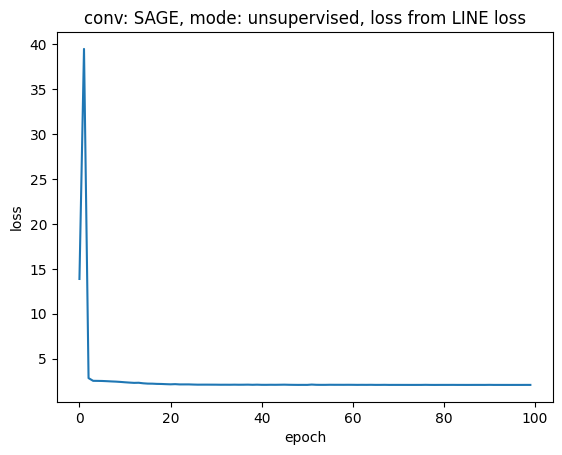

In [31]:
best_values={'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.008061289273891234, 'num_negative_samples': 1, 'lmbda': 0.48186987089486877}
loss_trgt=LINE
loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
loss_trgt["lmbda"] = best_values['lmbda']
M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
M.run(best_values)


In [ ]:
loss = LINE
loss_name = 'LINE'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]

                    loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                    loss_trgt["lmbda"] = best_values['lmbda']

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    #analysis.to_csv('../results/classification_with_MLP.csv')

In [ ]:
loss = HOPE_CN
loss_name = 'HOPE_CN'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]


                    loss_trgt["lmbda"] = best_values['lmbda']

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    analysis.to_csv('../results/classification_with_MLP.csv')


In [ ]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]

                    loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                    loss_trgt["lmbda"] = best_values['lmbda']

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)
                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    analysis.to_csv('../results/classification_with_MLP.csv')

# ниже надо еще редактировать

In [ ]:
loss = LapEigen
loss_name = 'LapEigen'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')

for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["lmbda"] = best_values['lmbda']


                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = HOPE_CN
loss_name = 'HOPE_CN'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis=analysis.drop(columns=['Unnamed: 0'])
for name in datasets_names[3:4]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = Node2Vec
loss_name = 'Node2Vec'
device= 'cpu'
for name in ['Cornell']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                loss_trgt["p"] = best_values['p']
                loss_trgt["q"] = best_values['q']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = VERSE_PPR
loss_name = 'VERSE_PPR'

device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')

for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
#on real graphs
loss = Force2Vec
loss_name = 'Force2Vec'

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
for name in datasets_names[2:]:
    for conv in ['GCN']:
         if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                MO = MainOptuna(name = name, conv = conv, device = device, loss_function = loss, mode = 'unsupervised')
                best_values = MO.run(number_of_trials =500)

                loss_trgt = dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name, conv=conv, device=device, loss_function=loss_trgt, mode='unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = VERSE_SR
loss_name = 'VERSE_SR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')

In [ ]:
modkdjfjf

In [ ]:
for (l,f,cl,asp,ad) in datasets_names:

In [22]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
number_of_trials = 100
import os
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph2_'+str(name)+'_attr.npy'):
        if len(analysis[(analysis['la'] == l)&(analysis['fa']==f)&(analysis['cl']==cl)&(analysis['asp']==asp)&(analysis['ad']==ad)] ) == 0:
            data, train_indices, test_indices, train_mask, test_mask = data_load(name)
            x = data.x.detach()
            y = data.y.detach()
            def objective(trial):
            # Integer parameter
                c = trial.suggest_categorical("c",  [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,20,30,100])
                clf = LogisticRegression(max_iter = 3000, C=c).fit(x[train_mask].numpy(), y[train_mask].numpy())

                accs_micro = []
                accs_macro = []
                for mask in [train_mask,test_mask,val_mask]:
                    accs_micro += [f1_score(data.y.detach()[mask].numpy(),clf.predict(x[mask].numpy()), average='micro')]
                    accs_macro += [f1_score(data.y.detach()[mask].numpy(),clf.predict(x[mask].numpy()), average='macro')]

                return np.sqrt(accs_micro[2]*accs_macro[2])

            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials = number_of_trials)
            trial = study.best_trial
            c=trial.params['c']
            clf = LogisticRegression(max_iter = 3000, C=c).fit(x[train_mask].numpy(), y[train_mask].numpy())
            accs_micro = []
            accs_macro = []
            for mask in [train_mask,test_mask,val_mask]:
                accs_micro += [f1_score(y[mask].numpy(),clf.predict(x[mask].numpy()), average='micro')]
                accs_macro += [f1_score(y[mask].numpy(),clf.predict(x[mask].numpy()), average='macro')]

            to_append = pd.Series([l,f,cl,asp,ad, accs_micro[0],accs_micro[1], accs_macro[0] , accs_macro[1]],index = analysis.columns)
            analysis = analysis.append(to_append, ignore_index=True)
            analysis.to_csv('classification_on_features.csv')


NameError: name 'analysis' is not defined

In [ ]:
loss = Force2Vec
loss_name = 'Force2Vec'
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
        print('hey')
        for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name = name, conv = conv, device = device, loss_function = loss, mode = 'unsupervised')
                best_values = MO.run(number_of_trials = 500)

                loss_trgt = dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_force2vec.csv')


In [ ]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
 
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = VERSE_SR
loss_name = 'VERSE_SR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')

In [ ]:
loss = VERSE_PPR
loss_name = 'VERSE_PPR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')


In [ ]:
loss = LapEigen
loss_name = 'LapEigen'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']


                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = LINE
loss_name = 'LINE'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = GraphFactorization
loss_name = 'GraphFactorization'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi, train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_CN
loss_name = 'HOPE_CN'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_AA
loss_name = 'HOPE_AA'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_RPR
loss_name = 'HOPE_RPR'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_Katz
loss_name = 'HOPE_Katz'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["betta"] = best_values['betta']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = Node2Vec
loss_name = 'Node2Vec'
device = 'cpu'
for name in ['chameleon']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                loss_trgt["p"] = best_values['p']
                loss_trgt["q"] = best_values['q']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = DeepWalk
loss_name = 'DeepWalk'
device='cpu'
for name in ['Citeseer']:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = APP
loss_name = 'APP'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                